# Notebook 04 — Advanced Analysis

In [71]:
# Standard library
from pathlib import Path

# Notebook setup
from utils.notebook_setup import setup_notebook

# Data handling
import numpy as np
import pandas as pd
from utils.data_loading import load_data

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from utils.viz_style import CLUSTER_COLORS

# Preprocessing / feature engineering
from sklearn.preprocessing import StandardScaler

# Model evaluation
from sklearn.metrics import (
    mean_absolute_error,
    root_mean_squared_error,
    r2_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)

# Explaining
import shap

# Clustering/dimensionality reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Persistence
import joblib

# 2. Settings / Configuration

In [72]:
setup_notebook(seed=42)

# 3. Loading data and setup

## 3.1 Loading data

In [73]:
df_clean, clean_meta = load_data("../data/processed/clean_data.csv")

In [74]:
variables_info, var_meta = load_data("../data/metadata/variables_info.csv")

In [75]:
variables_info.head()

,Variable,Description
0,id,Unikalny identyfikator respondenta w bazie łąc...
1,intid,ID wywiadu
2,waga_proba,Waga próby bez korekty przypadków ekstremalnyc...
3,waga_proba_kor,Waga próby z korektą przypadków ekstremalnych ...
4,waga_pop,Waga populacyjna bez korekty przypadków ekstre...


## 3.2 Setup

In [76]:
models_path = Path("../models")

In [77]:
#Artifacts created in 03_modelling.ipynb
best_model = joblib.load(models_path / "best_model.pkl")
X_train_a_scaled = joblib.load(models_path / "X_train_a_scaled.pkl")
X_test_a_scaled = joblib.load(models_path / "X_test_a_scaled.pkl")
X_train_all = joblib.load(models_path / "X_train_all.pkl")
y_train = joblib.load(models_path / "y_train.pkl")

In [78]:
likert_predictors = [f"j1_{str(i).zfill(2)}" for i in range(1, 11)]
likert_predictors += [f"j3_{str(i).zfill(2)}" for i in range(1, 14)]
likert_predictors += ["m13"]  

# 4. Explainability & Analysis

## 4.1 SHAP

SHAP explainer created for the trained model - SHAP values computed for both training and test sets.

In [79]:
explainer = shap.Explainer(best_model, X_train_a_scaled)
shap_values_train = explainer(X_train_a_scaled)
shap_values_test = explainer(X_test_a_scaled)

In [80]:
desc_map = dict(zip(variables_info["Variable"], variables_info["Description"]))
dict_names = [
    f"{col} — {desc_map.get(col, '')}" for col in X_train_all.columns
]

A summary plot of SHAP values is generated for the test and training data to show which features contribute most to predictions.

#### SHAP summary – test data

This plot shows the global importance of features and the direction of their impact on the model output.

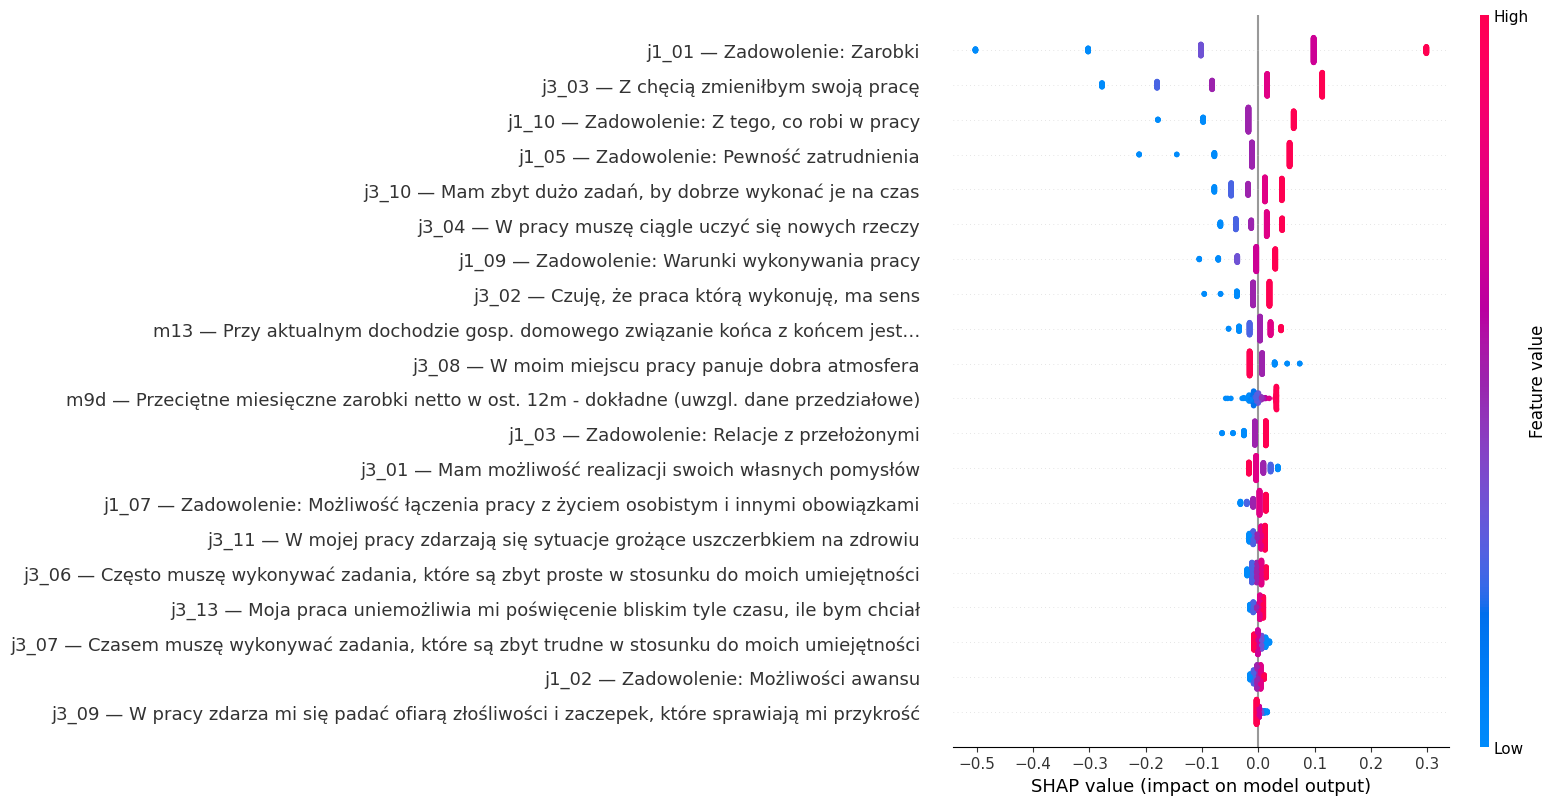

In [81]:
shap.summary_plot(
    shap_values_test, 
    X_test_a_scaled,
    feature_names = dict_names,
    show=True 
)

From the graph, it can be observed that the variable with the strongest impact is personal satisfaction with earnings, measured on a 1-5 Likert scale. Interestingly, this factor is a stronger predictor than respondents’ actual income levels.

Two other strong positive predictors are satisfaction with one’s actual work tasks and employment security. The strongest negative predictor - unsurprisingly - is the desire to change jobs.

Among other notable predictors, a positive one is the need to continuously learn at work, while a negative one is having too many tasks to complete within deadlines.

#### SHAP summary – training data

This plot shows the global importance of features and the direction of their impact on the model output.

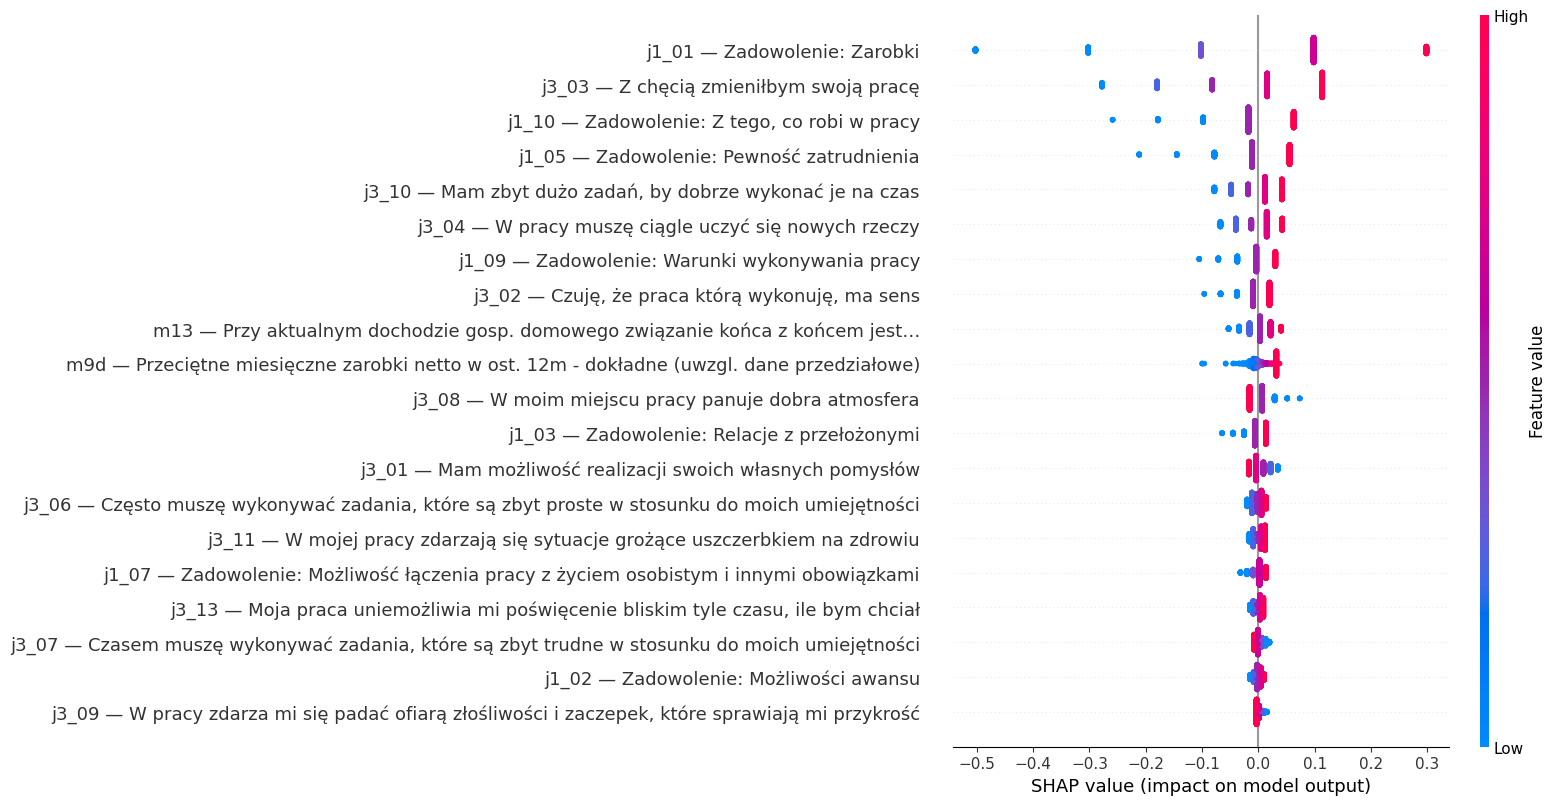

In [82]:
shap.summary_plot(
    shap_values_train, 
    X_train_a_scaled,
    feature_names = dict_names 
)

The SHAP summary plots for train and test data look almost identical. To verify that the SHAP values were truly different, the correlation of mean absolute SHAP values per feature was calculated.

In [83]:
train_means = np.abs(shap_values_train.values).mean(axis=0)
test_means = np.abs(shap_values_test.values).mean(axis=0)
correlation = np.corrcoef(train_means, test_means)[0,1]

print("Correlation of mean absolute SHAP values (train vs test):", correlation)

Correlation of mean absolute SHAP values (train vs test): 0.9993966513604301


The correlation is extremely high (~0.999), which is expected for a linear model on standardized features.

#### SHAP waterfall - single instance

SHAP values are computed for a single test instance to interpret the model's prediction.

In [84]:
x_instance = pd.DataFrame(
    X_test_a_scaled[0].reshape(1, -1),
    columns=X_train_all.columns
)
shap_values_single = explainer(x_instance)

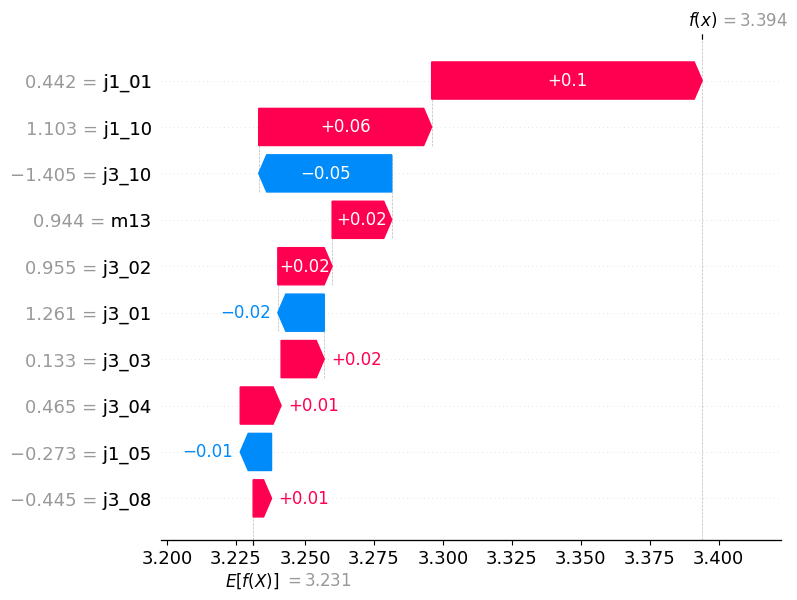

,Code,Description
0,j1_01,Zadowolenie: Zarobki
1,j1_10,"Zadowolenie: Z tego, co robi w pracy"
2,j3_10,"Mam zbyt dużo zadań, by dobrze wykonać je na czas"
3,m13,Przy aktualnym dochodzie gosp. domowego związa...
4,j3_02,"Czuję, że praca którą wykonuję, ma sens"
5,j3_01,Mam możliwość realizacji swoich własnych pomysłów
6,j3_03,Z chęcią zmieniłbym swoją pracę
7,j3_04,W pracy muszę ciągle uczyć się nowych rzeczy
8,j1_05,Zadowolenie: Pewność zatrudnienia
9,j3_08,W moim miejscu pracy panuje dobra atmosfera


In [85]:
top_idx = np.argsort(np.abs(shap_values_single.values[0]))[::-1][:10]
shap.plots.waterfall(shap_values_single[0][top_idx])

top_features = X_train_all.columns[top_idx]

feature_table = pd.DataFrame({
    "Code": top_features,
    "Description": [variables_info.loc[variables_info.Variable==c, "Description"].values[0] 
                    for c in top_features]
})

display(feature_table)

## 4.2 Clustering and PCA

### 4.2.1 Preparing SHAP values

PCA and clustering were performed on the training dataset (960 samples) because it provides a more stable estimate of variance and better representation of the data structure.

In [86]:
shap_values_df = pd.DataFrame(shap_values_train.values, columns=X_train_all.columns)
print(shap_values_df.isnull().values.any())

False


In [87]:
scaler = StandardScaler()
shap_scaled = scaler.fit_transform(shap_values_df)
print(shap_values_df)

        j1_01     j1_02     j1_03     j1_04     j1_05     j1_06     j1_07  \
0   -0.102080 -0.002194 -0.006216  0.002247 -0.011353 -0.001068  0.002034   
1    0.098077 -0.014733  0.013208  0.002247 -0.011353 -0.005176  0.013334   
2    0.098077  0.004075 -0.006216 -0.001766 -0.011353 -0.001068  0.002034   
3   -0.102080 -0.008463 -0.006216  0.002247  0.055430  0.003040 -0.009266   
4    0.098077  0.004075  0.013208  0.002247  0.055430 -0.001068  0.013334   
..        ...       ...       ...       ...       ...       ...       ...   
955  0.098077 -0.002194  0.013208  0.002247 -0.011353 -0.001068  0.002034   
956 -0.102080 -0.002194 -0.025639 -0.005779 -0.078137  0.003040 -0.009266   
957 -0.102080 -0.002194 -0.006216  0.002247 -0.078137 -0.001068  0.002034   
958 -0.102080 -0.002194  0.013208  0.002247  0.055430 -0.001068 -0.009266   
959  0.098077 -0.002194  0.013208 -0.001766 -0.011353 -0.001068  0.002034   

        j1_08     j1_09     j1_10  ...     j3_06     j3_07     j3_08  \
0  

### 4.2.2 Determining number of clusters

The elbow method is used to determine the optimal number of clusters by plotting inertia for k values from 2 to 9.

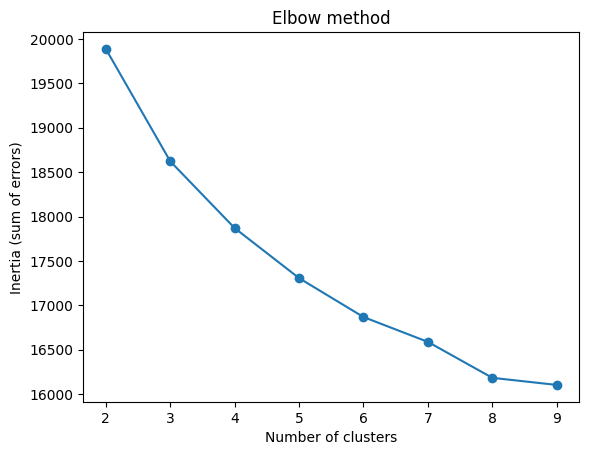

In [88]:
inertia = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(shap_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 10), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (sum of errors)')
plt.title('Elbow method')
plt.show()

KMeans clustering performed with k=7 clusters.

### 4.2.3 Clustering and PCA visualization

In [89]:
k = 7 
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(shap_scaled)

shap_values_df['cluster'] = clusters

In [90]:
# Reducing dimensionality to 2D for plotting
pca = PCA(n_components=2)
shap_2d = pca.fit_transform(shap_scaled)

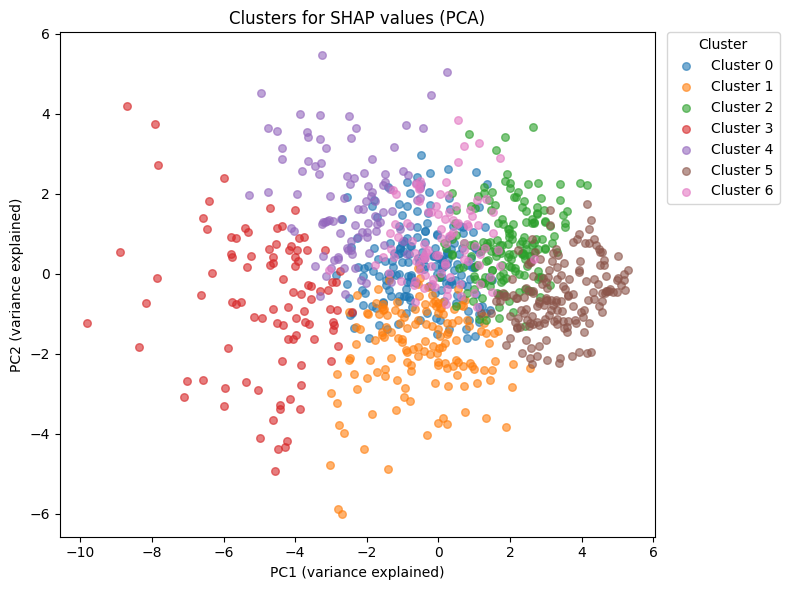

In [91]:
plt.figure(figsize=(8, 6))
for cluster_id, color in CLUSTER_COLORS.items():
    mask = clusters == cluster_id
    plt.scatter(
        shap_2d[mask, 0],
        shap_2d[mask, 1],
        color=color,
        label=f"Cluster {cluster_id}",
        alpha=0.6,
        s=30
    )
plt.title("Clusters for SHAP values (PCA)")
plt.xlabel("PC1 (variance explained)")
plt.ylabel("PC2 (variance explained)")
plt.legend(
    title="Cluster",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0
)
plt.tight_layout()
plt.show()

### 4.2.4 Cluster profiles

In [92]:
cluster_profiles = shap_values_df.groupby('cluster').mean()

In [93]:
shap_values_df['satisfaction'] = y_train.values

cluster_summary = shap_values_df.groupby('cluster')['satisfaction'].agg(['mean', 'std', 'count'])
print(cluster_summary)

             mean       std  count
cluster                           
0        3.257895  0.473438    190
1        3.170068  0.501698    147
2        3.508982  0.501423    167
3        2.622449  0.710964     98
4        2.930693  0.533993    101
5        3.584906  0.598541    159
6        3.255102  0.579926     98


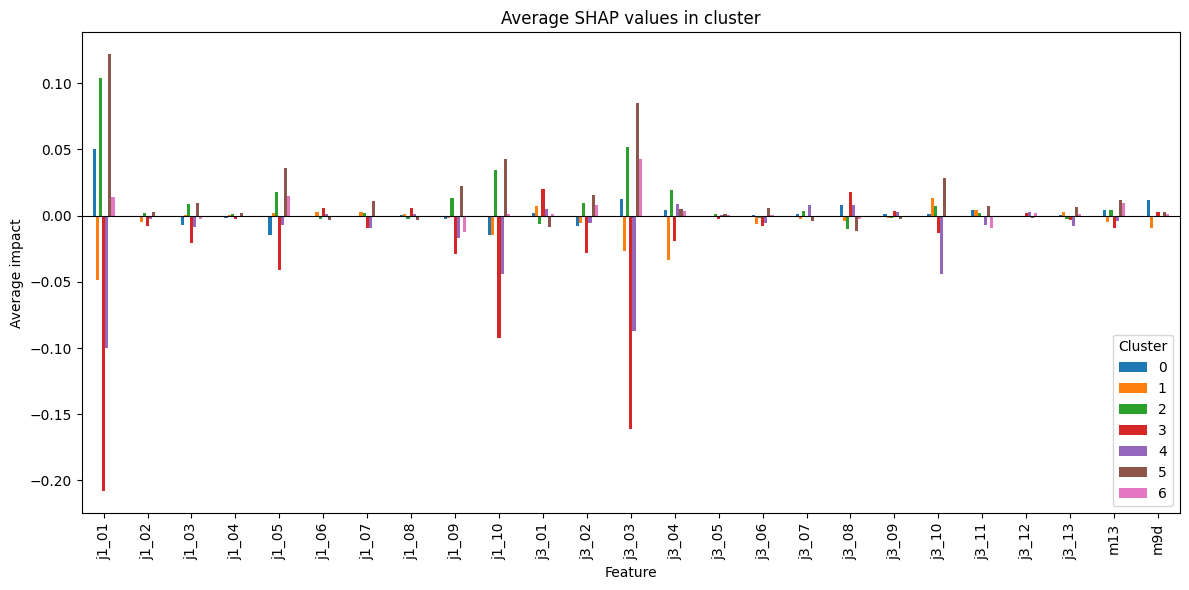

In [94]:
cluster_profiles.T.plot(kind='bar', figsize=(12, 6))
plt.title("Average SHAP values in cluster")
plt.axhline(0, color="black", linewidth=0.8)
plt.xlabel("Feature")
plt.ylabel("Average impact")
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

### 4.2.5 Cluster-wise SHAP plots

Color-coded bar plots are generated for each cluster to visualize the average SHAP values per feature.  
Positive contributions are shown in red, negative contributions in blue.

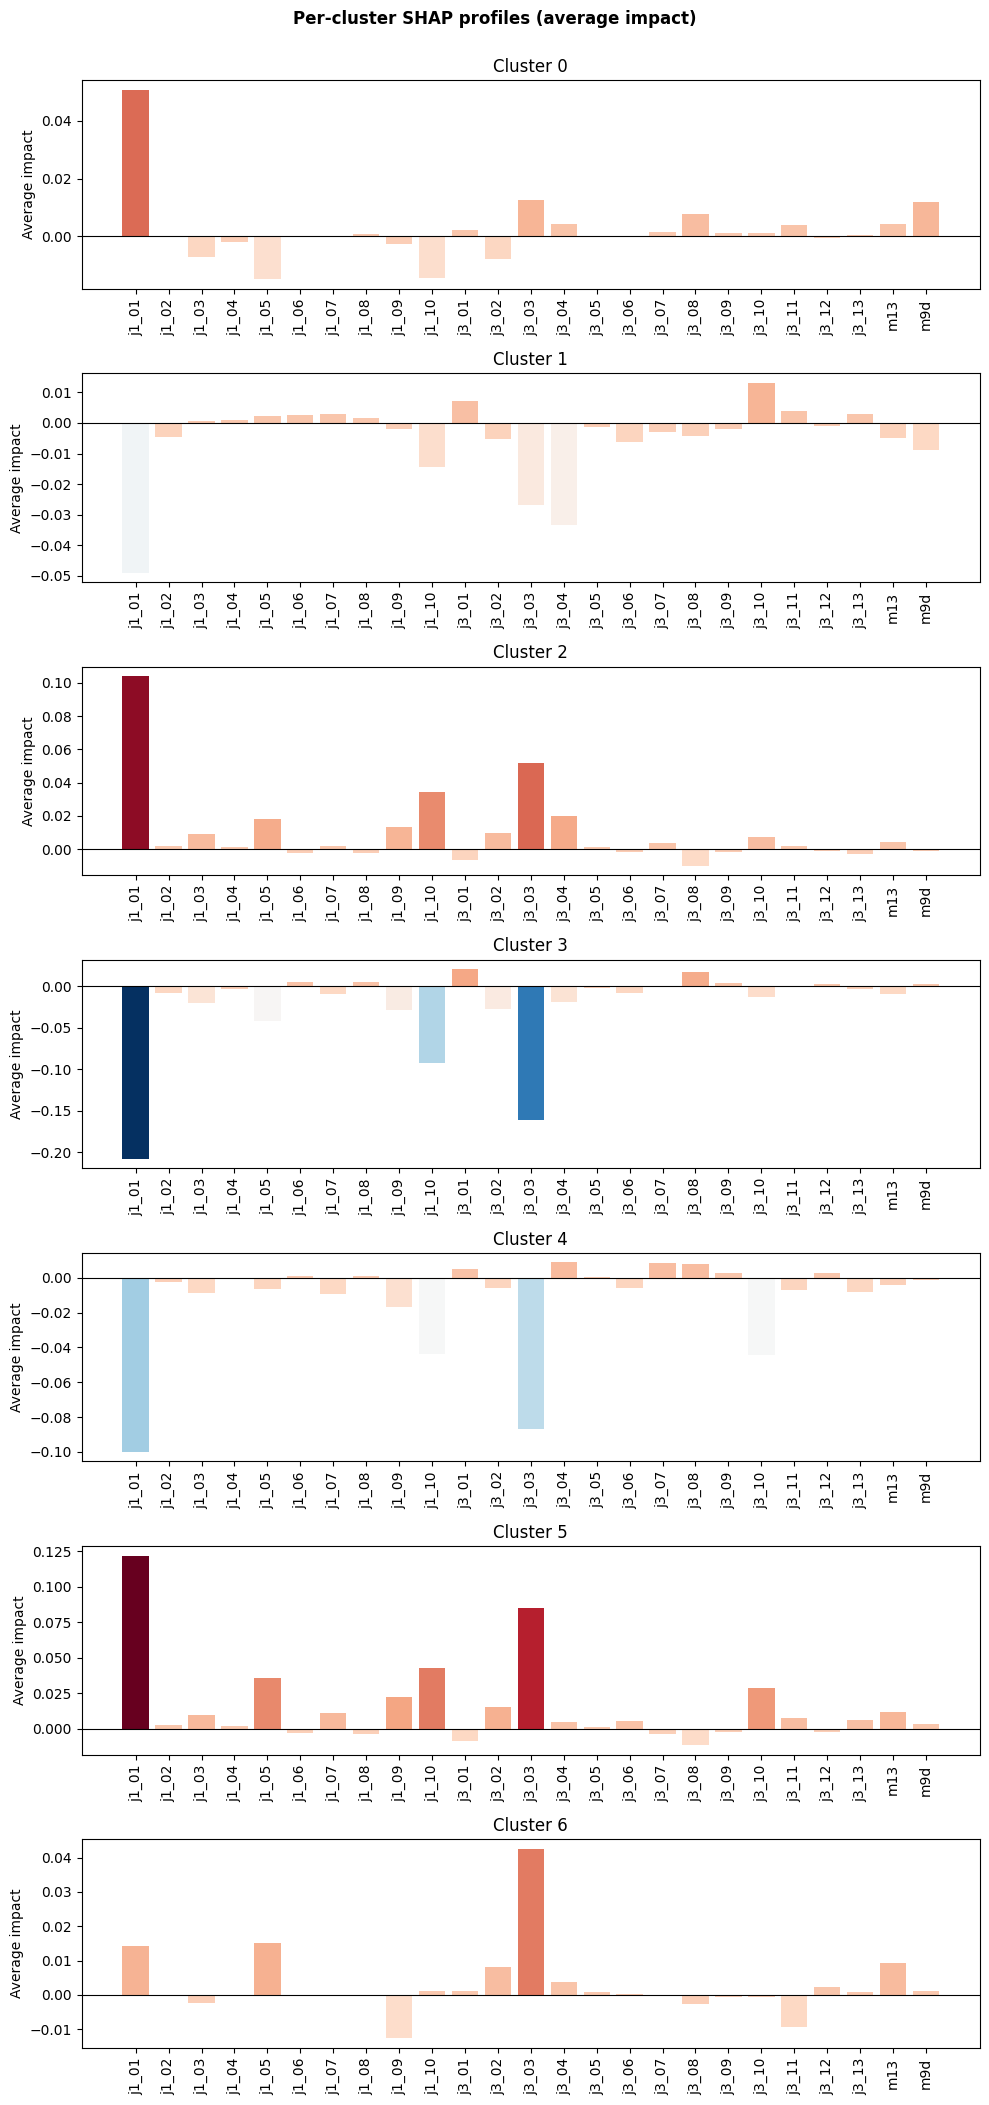

In [95]:
clusters_sorted = sorted(shap_values_df['cluster'].unique())

cmap = cm.get_cmap('RdBu_r')  # reversed so red=positive, blue=negative
vmax = cluster_profiles.values.max()
vmin = cluster_profiles.values.min()

fig, axes = plt.subplots(nrows=len(clusters_sorted), figsize=(10, 3 * len(clusters_sorted)))

for i, cluster_id in enumerate(clusters_sorted):
    ax = axes[i]
    vals = cluster_profiles.loc[cluster_id]
    colors = [cmap((v - vmin) / (vmax - vmin)) for v in vals.values]
    ax.bar(vals.index, vals.values, color=colors)
    ax.axhline(0, color='black', linewidth=0.8)
    fig.suptitle("Per-cluster SHAP profiles (average impact)", fontweight="bold", y=1)
    ax.set_title(f"Cluster {cluster_id}")
    ax.set_ylabel("Average impact")
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

### 4.2.6 Assessing the quality of clusterization

In [96]:
ch = calinski_harabasz_score(shap_scaled, clusters)
db = davies_bouldin_score(shap_scaled, clusters)

print(f"Calinski-Harabasz: {ch:.2f}")
print(f"Davies-Bouldin: {db:.2f}")

Calinski-Harabasz: 70.96
Davies-Bouldin: 2.88


The clustering exhibits moderate separation between groups.  
The Calinski-Harabasz index of 70.96 suggests reasonably distinct clusters, while the Davies-Bouldin index of 2.88 indicates some overlap between clusters.  
Overall, the clusters are acceptable for exploratory analysis of SHAP-based feature patterns.

### 4.2.7 Cluster-Level Analysis of Job Satisfaction (Based on SHAP Values)

| Cluster | Mean Satisfaction | Std. Dev. | n  | Summary Description |
|:--------:|:----------------:|:----------:|:--:|:--------------------|
| **4 (Happy Core)** | **3.61** | 0.52 | 199 | *The “Goal-Driven Satisfied.”* Highest overall satisfaction. Strongest positive impact from **earnings (j1_01)**, **job meaning (j3_02)**, and **learning opportunities (j3_04)**. Mild negative impact of *good atmosphere* (j3_08) and *carrying out own ideas* (j3_01) suggests their satisfaction depends more on extrinsic structure (pay, stability) than soft factors. |
| **2 (Satisfied Baseline)** | **3.43** | 0.60 | 137 | *The “Conditions & Stability Satisfied.”* High satisfaction driven by **pay (j1_01)**, **job stability (j1_05)**, and **work conditions (j1_09)**. Mild negative impact of *learning new things (j3_04)* - they value comfort and balance over novelty. |
| **6 (Financially Motivated)** | **3.30** | 0.49 | 241 | *Largest cluster.* Satisfaction is tied to both **subjective pay satisfaction (j1_01)** and **actual income (m9d)**. Other mild positive predictors: *good atmosphere (j3_08)* and *manageable workload (j3_10)*. Indicates strong financial orientation. |
| **5 (Survivalists / At-Risk)** | **3.28** | 0.75 | 18 | *Smallest cluster.* Dominated by **m13 (ease of making ends meet)** as the key predictor - job satisfaction closely tied to financial security. Large variability (σ = 0.75) reflects heterogeneity in this small group. |
| **1 (Homogeneously Disengaged)** | **3.09** | 0.45 | 138 | *Low variation, slightly below-average satisfaction.* Negative SHAP impacts from **earnings (j1_01)** and **learning (j3_04)** suggest disinterest in development. Prefer predictable, stable work but remain only moderately satisfied. |
| **0 (Dissatisfied Status Quo)** | **2.99** | 0.55 | 131 | *Moderately dissatisfied.* Negative impacts from **earnings (j1_01)** and **work engagement (j3_03)** imply they remain unhappy despite positive conditions. Slight positive from *learning new things (j3_04)* hints at some latent motivation for growth. |
| **3 (Trapped / Compensated Dissatisfied)** | **2.60** | 0.70 | 96 | *Most dissatisfied cluster.* Strong negative SHAP effects for **pay satisfaction (j1_01)** and **unwillingness to leave (j3_03)** - suggesting employees stay despite deep dissatisfaction (“compensated dissatisfaction”). Only mild positives: *autonomy (j3_01)* and *good atmosphere (j3_08).* |

---

#### Key Patterns & Interpretations

- **Reversed Predictors (Clusters 0, 1, 3):** For these groups, satisfaction with earnings (*j1_01*) and retention intent (*j3_03*) show **negative** SHAP impacts - a “compensated dissatisfaction” pattern where higher pay does not translate into happiness.
- **Financial Sensitivity (Clusters 4, 5, 6):** Satisfaction is **strongly driven by financial factors** - either perceived (j1_01) or objective (m9d, m13).
- **Learning and Growth:** Interest in self-development differentiates clusters.  
  - Positive in **Cluster 0** and **Cluster 4**  
  - Negative in **Cluster 1** and **Cluster 2**
- **Atmosphere and Autonomy:** Only **Cluster 3** shows clear improvement from a *good atmosphere* and *autonomy*, reinforcing that social and creative support matter most for the most dissatisfied.


#### Notable SHAP Insight Example
> *For clusters 0, 1, and 3, satisfaction with earnings (j1_01) has a significant inverse relationship with overall job satisfaction. This suggests a “compensated dissatisfaction” dynamic where higher pay acts as a counterbalance for deeper discontent.*


#### Overall Summary
Across the clusters, job satisfaction divides into three broad patterns:
1. **Financially anchored satisfaction** (Clusters 4, 5, 6)  
2. **Stability/condition-based satisfaction** (Cluster 2)  
3. **Compensated dissatisfaction** (Clusters 0, 1, 3)

Overall, these clusters reveal that people find satisfaction in very different ways — some through pay and stability, others despite them.

In [97]:
feature_labels = pd.DataFrame({
    "Variable": cluster_profiles.columns,  
}).merge(variables_info, on="Variable", how="left")

display(feature_labels)

,Variable,Description
0,j1_01,Zadowolenie: Zarobki
1,j1_02,Zadowolenie: Możliwości awansu
2,j1_03,Zadowolenie: Relacje z przełożonymi
3,j1_04,Zadowolenie: Kontakty ze współpracownikami
4,j1_05,Zadowolenie: Pewność zatrudnienia
5,j1_06,Zadowolenie: Możliwość rozwoju osobistego i po...
6,j1_07,Zadowolenie: Możliwość łączenia pracy z życiem...
7,j1_08,Zadowolenie: Możliwość wykazania się inicjatyw...
8,j1_09,Zadowolenie: Warunki wykonywania pracy
9,j1_10,"Zadowolenie: Z tego, co robi w pracy"


### 4.2.8 Assessing intergenerational differences

In [98]:
# Average satisfaction
predictor_cols_for_avg = likert_predictors + ['satisfaction']
avg_satisfaction_by_generation = df_clean.groupby('generation')[predictor_cols_for_avg].mean().reindex(['BB', 'X', 'M', 'Z', 'A'])
print("\nAverage satisfaction, by generation:")
print(avg_satisfaction_by_generation)


Average satisfaction, by generation:
               j1_01     j1_02     j1_03     j1_04     j1_05     j1_06  \
generation                                                               
BB          3.403846  2.980769  4.237179  4.435897  4.352564  3.653846   
X           3.422472  3.080899  4.249438  4.408989  4.155056  3.698876   
M           3.700000  3.254545  4.218182  4.415909  4.263636  3.720455   
Z           3.825000  3.350000  4.406250  4.562500  4.262500  3.843750   
A                NaN       NaN       NaN       NaN       NaN       NaN   

               j1_07     j1_08     j1_09     j1_10  ...     j3_06     j3_07  \
generation                                          ...                       
BB          3.839744  3.993590  4.025641  4.237179  ...  2.967949  3.794872   
X           3.892135  4.002247  4.031461  4.134831  ...  3.224719  3.741573   
M           3.900000  4.040909  4.118182  4.127273  ...  3.165909  3.743182   
Z           3.843750  4.100000  4.218750  4.2437

In [99]:
avg_satisfaction_by_generation.head()

,j1_01,j1_02,j1_03,j1_04,j1_05,j1_06,j1_07,j1_08,j1_09,j1_10,...,j3_06,j3_07,j3_08,j3_09,j3_10,j3_11,j3_12,j3_13,m13,satisfaction
generation,,,,,,,,,,,,,,,,,,,,,
BB,3.403846,2.980769,4.237179,4.435897,4.352564,3.653846,3.839744,3.993590,4.025641,4.237179,...,2.967949,3.794872,4.339744,4.217949,3.692308,3.339744,3.467949,3.583333,3.903846,3.192308
X,3.422472,3.080899,4.249438,4.408989,4.155056,3.698876,3.892135,4.002247,4.031461,4.134831,...,3.224719,3.741573,4.312360,4.339326,3.669663,3.368539,3.516854,3.485393,3.829213,3.231461
M,3.700000,3.254545,4.218182,4.415909,4.263636,3.720455,3.900000,4.040909,4.118182,4.127273,...,3.165909,3.743182,4.293182,4.327273,3.640909,3.581818,3.763636,3.572727,4.038636,3.261364
Z,3.825000,3.350000,4.406250,4.562500,4.262500,3.843750,3.843750,4.100000,4.218750,4.243750,...,3.125000,3.756250,4.456250,4.525000,3.687500,3.718750,4.025000,3.687500,4.200000,3.287500
A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
# Dropping Gen A due to missing data
avg_satisfaction_by_generation_clean = avg_satisfaction_by_generation.drop(index='A')

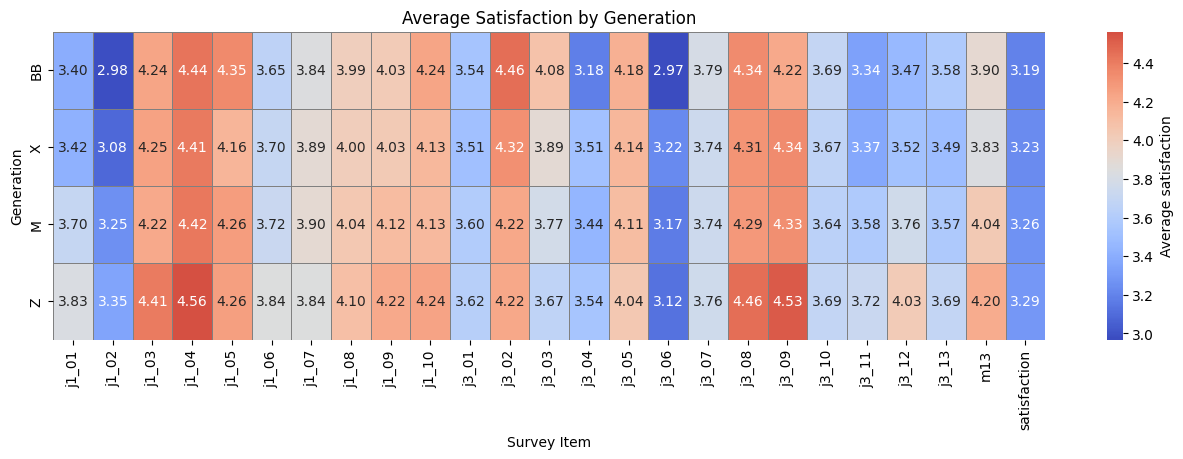

In [106]:
plt.figure(figsize=(16, 4))

sns.heatmap(
    avg_satisfaction_by_generation_clean,      
    annot=True,                          
    fmt=".2f",                           
    cmap="coolwarm",                     
    linewidths=0.5,
    linecolor="gray",
    center=avg_satisfaction_by_generation_clean.values.mean(),
    cbar_kws={'label': 'Average satisfaction'}
)

plt.title("Average Satisfaction by Generation")
plt.xlabel("Survey Item")
plt.ylabel("Generation")
plt.show()

**Generational Patterns in Satisfaction**

Gen Z tends to report the highest satisfaction across most aspects, while Baby Boomers generally show the lowest.  
It’s hard to tell whether this difference comes from age itself or from generational attitudes.

**Variables with the lowest average satisfaction**
- **j3_06** - Feeling that tasks are too easy for one’s skillset.  
- **j1_02** - Opportunities for promotion.  
- **Overall job satisfaction.**


**Variables with the highest average satisfaction**
- **m13** - Ability to make ends meet with household income.  
- **j1_04** - Relations with coworkers.  
- **j3_09** - Lack of workplace harassment.

Millennials report finding it easiest to make ends meet among all generations.


**Notable cross-generational patterns**
- For many variables, **Gen X scores slightly lower** than both Baby Boomers and Millennials - e.g.:
  - **Job stability (j1_05)**
  - **Ability to spend enough time with loved ones (j3_13)**


- Reverse trend for **j3_04** (learning new things at work):  
  Gen X is *more satisfied* with opportunities to learn, and also feels *less underchallenged* by simple tasks (**j3_06**) than other generations.


- **Reverse satisfaction trends** (Baby Boomers most satisfied, younger generations less):  
  - Job stability (**j1_05**)  
  - Feeling work has meaning (**j3_02**)  
  - Lack of willingness to change jobs (**j3_03**)  
  - Utilizing knowledge and skills (**j3_05**)
  

**Largest intergenerational differences**
- **m13** - Ease of making ends meet: big leap between Millennials (highest) and Gen X, and another between Gen X and Baby Boomers.  
- **j3_06** - Tasks too easy for skillset: Baby Boomers feel their skills are most underutilized.  
- **j1_02** - Opportunities for promotion: Baby Boomers feel most “stuck.”  
- **j3_04** - Needing to learn new things at work: increase from Baby Boomers to Gen X.  
- **j3_12** - Work’s negative health impact: strong increases between Gen X → Millennials → Gen Z.  
- **j3_09** - Workplace harassment: Gen Z reports the least, notably less than Millennials.